# Kolmogorov flow with JAX in Hydrogym

A recent development of Hydrogym is the inclusion of differentiable solvers like ``JAX``. The idea is to leverage the differentiable environment to compute sensitivity studies that can lead to a better controller with less compute time. This tutorial covers how to set up the Kolmogorov JAX environment, how to run basic control, and how to run reinforment learning on the environment (to be added shortly). Currently, the Kolmogorov flow is the main differentiable flow environment implemented in Hydrogym. For more details on the mathematical background of the Kolmogorov flow, please refer to the L4DC paper [1]. 

## 1. Running the environment 

In [12]:
###### Import necessary functions ####### 
import os, time 
import jax.numpy as jnp 
import matplotlib.pyplot as plt
import seaborn as sns
from hydrogym.jax.solvers.base import RK4CNSolver 
from hydrogym.jax.flow import FlowConfig
from hydrogym.jax.utils import io as io

### Include postprocessing to monitor results 

In [13]:
print_fmt = (
    "vel1: {0:0.3f}\t\t vel2: {1:0.3f}\t\t vel3: {2:0.3e}\t\t vel4: {3:0.3e}"
)

def log_postprocess(flow):
    '''
    The default observation is the velocity at 64 equally spaced points along the domain.
    This postprocess function is computing the mean of the observations.
    '''
    obs = flow.get_observations()
    mean_obs_time = jnp.mean(obs, axis=1)
    return (mean_obs_time)

output_dir = 'kolmogorov_data'
np_file_name = 'kolmogorov_trajectory'
gif_file_name = 'kolmogorov'
os.makedirs(output_dir, exist_ok=True)

### Set up solver parameters and run 

Some notes: 
- If you would like to change the grid resolution, define it as an argument of FlowConfig, like ``FlowConfig(domain_x = 256, domain_y = 256)... `` default is 64x64 
- If you would like to change Reynolds number, specifically to view extreme events, set ``flow.Re``to be between 40 - 80. The default Reynolds number is 200, a fully turbulent state.

In [14]:
flow = FlowConfig() 
flow.Re = 100 
dt = 0.001
solver = RK4CNSolver(flow, dt, 1)
end_time = 50 # This is in seconds!

callbacks = [
    io.LogCallback(
        postprocess=log_postprocess,
        interval=1,
        filename=f"{output_dir}/kolmogorov.dat",
        print_fmt=print_fmt,
    ),
]

######## Check what device JAX is using! #######
# If you have access to a GPU, this should run much faster and you can improve grid resolution, default is 64x64 
# Otherwise, this still runs pretty fast. 
 
def check_jax_device():
    from jax.lib import xla_bridge
    device = xla_bridge.get_backend().platform
    print(f"JAX is using: {device}")

check_jax_device()
start = time.time()
final, trajectory = solver.solve(dt, flow, (0,end_time), callbacks, None, save_n=1)
end = time.time()
jnp.save(output_dir + '/' + np_file_name, trajectory)
print("Total time:", end - start)

/tmp/ipykernel_95634/2176996286.py:22: DeprecationWarning: jax.lib.xla_bridge.get_backend is deprecated; use jax.extend.backend.get_backend.
  device = xla_bridge.get_backend().platform


JAX is using: cpu
Total time: 81.3811686038971


### Visualize results 

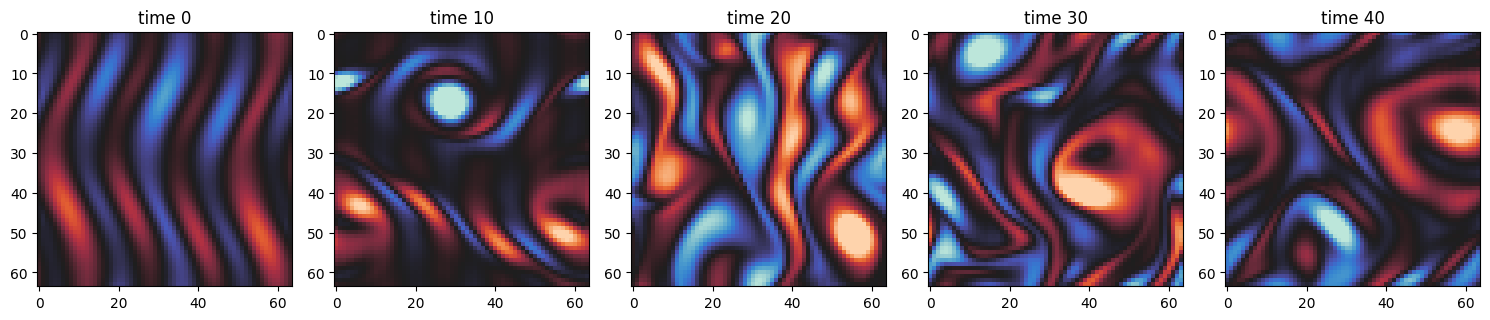

In [15]:
cols = 5
fig, axs = plt.subplots(1, cols, figsize=(15, 5))

simulation = jnp.load(output_dir + '/' + np_file_name + '.npy')

data = jnp.fft.irfftn(simulation, axes=(1,2))

for i in range(cols):
    time = int(len(data) * (i/cols))
    axs[i].imshow(data[time], cmap='icefire', vmin=-8, vmax=8)
    axs[i].set_title('time {}'.format(time))

plt.tight_layout()
plt.show()

### Optional: Generate a gif 

In [30]:
import numpy as np
import imageio.v2 as imageio  

frames = []
for i in range(data.shape[0]):
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(data[i], cmap='icefire')  
    ax.axis('off')
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    frames.append(image)

    plt.close(fig)

imageio.mimsave(output_dir + '/' + gif_file_name + '.gif', frames, fps=10)  


/tmp/ipykernel_42977/684810181.py:10: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


## 2. Adding simple control

To add a controller to the system, simply specify the desired controller under `flow.control_function`. For instance, if I would like a control of sinusoidal forcing of wavenumber 4 and amplitude of -0.5, I would execute the following:

In [19]:
x, y = flow.load_mesh(name='')

def control_func(a, k, y):
    return (a*jnp.sin(k*y),  jnp.zeros_like(y))

flow.control_function = control_func(-0.6, 4, y)
final, trajectory = solver.solve(dt, flow, (0, end_time), callbacks, None, save_n=1)
jnp.save(output_dir + '/' + 'kolmogorov_controlled', trajectory)


### Visualize controlled results

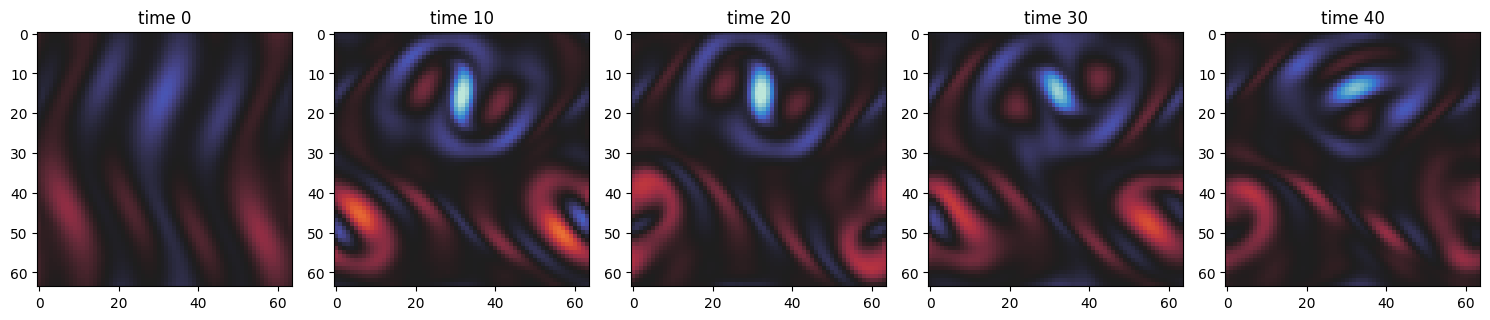

In [20]:
cols = 5
fig, axs = plt.subplots(1, cols, figsize=(15, 5))

simulation = jnp.load(output_dir + '/' + 'kolmogorov_controlled' + '.npy')

data = jnp.fft.irfftn(simulation, axes=(1,2))

for i in range(cols):
    time = int(len(data) * (i/cols))
    axs[i].imshow(data[time], cmap='icefire', vmin=-8, vmax=8)
    axs[i].set_title('time {}'.format(time))

plt.tight_layout()
plt.show()

# References

[1] Jared Callaham, Sajeda Mokbel, Samuel Ahnert, Kai Lagemann, Esther Lagemann,
Nikolaus Adams, Christian Lagemann, Ludger Paehler, and Steven Brunton. 2025.
HydroGym: A Reinforcement Learning Platform for Fluid Dynamics. Accepted
to the Conference on Learning for Dynamics and Control (L4DC).
